In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor


DATA_DIR = (os.getcwd() + "/data/")
PREDICTION_DIR = (os.getcwd() + "/predictions_new/")
start_date = '1999-01-01'
end_date = "2019-12-31"
# Get fundamental data for each stock in the ticker and append to the dataframe




def get_all_symbols():
    return [v.strip('.csv') for v in os.listdir(DATA_DIR)]

def get_current_predictions():
    return [v.strip('_predictions.csv') for v in os.listdir(PREDICTION_DIR)]


tickers = get_all_symbols()
predicted_tickers = get_current_predictions()

df = pd.read_csv(DATA_DIR + 'AAPL' + '.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Short Term Reversal,Stock Momentum,...,volatility_60,annual_volatility,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),BBWidth,Williams
0,2000-02-02,0.899554,0.911830,0.866071,0.882254,0.748854,464195200,0.985661,-0.103234,-0.103234,...,0.334862,0.615731,12.887812,38.601964,46.032351,-52.968329,-38.058805,50.075000,0.271230,-78.232938
1,2000-02-03,0.895647,0.930804,0.895089,0.922433,0.782958,475193600,1.045541,-0.060796,-0.060796,...,0.326373,0.613843,68.872138,49.082313,50.475236,-4.110540,0.497970,65.042087,0.271101,-67.361058
2,2000-02-04,0.928013,0.982143,0.925223,0.964286,0.818483,425320000,1.045372,0.062731,0.062731,...,0.320394,0.613414,86.691183,57.830098,54.662242,61.334045,57.788830,86.151739,0.264072,-49.999777
3,2000-02-07,0.964286,1.020089,0.945871,1.018415,0.864427,441067200,1.056134,0.099398,0.099398,...,0.324097,0.614508,94.635062,66.511261,59.438451,112.326875,108.180699,104.977473,0.275773,-27.546248
4,2000-02-08,1.017857,1.036830,0.993304,1.025670,0.870585,408643200,1.007124,0.145886,0.145886,...,0.324073,0.614204,95.375077,67.555676,60.045999,134.926973,135.553646,115.982182,0.282727,-24.536729


In [2]:
def make_to_monthly(ticker):
    df = pd.read_csv(DATA_DIR + ticker + '.csv', parse_dates=True, index_col='Date')
    print(df.columns)
    agg_functions = {
        'Open': 'first',   # First value in the month for 'Open'
        'Close': 'last',   # Last value in the month for 'Close'
        'Adj Close': 'last',  # Last value in the month for 'Adj Close'
        'Volume': 'mean',   # Sum of 'Volume' in the month
        'Returns': 'prod',
        'High': 'max',     # Maximum value of 'High' in the month
        'Low': 'min',       # Minimum value of 'Low' in the month
        'Stock Momentum': 'mean',  # Mean of 'Stock Momentum' in the month
        'Short Term Reversal': 'mean',  # Mean of 'Short Term Reversal' in the month
        'Long Term Reversal': 'mean',  # Mean of 'Long Term Reversal' in the month
        'Total Returns': 'mean',  # Mean of 'Total Returns' in the month
        'Market_Beta': 'mean',
        'Turnover Volatility': 'mean',
        'Total Return Volatility': 'mean',
        'SMA_5': 'last',
        'SMA_20': 'last',
        'SMA_50': 'last',
        'SMA_252': 'last',
        'adv20': 'last',
        'VWAP': 'last',
        'log_returns': 'mean',
        'volatility_30': 'last',
        'volatility_60': 'last',
        'annual_volatility': 'last',
        'RSI(2)': 'last',
        'RSI(7)': 'last',
        'RSI(14)': 'last',
        'CCI(30)': 'last', 'CCI(50)': 'last', 'CCI(100)': 'last', 'BBWidth': 'last', 'Williams': 'last'
    }
    
    monthly = df.resample('M').agg(agg_functions)
    return monthly
    
    


#make_to_monthly('AAPL')


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Get the S&P 500 constituents
sp500_constituents_url = "https://en.wikipedia.org/wiki/List_of_S&P_500_companies"
sp500_constituents_df = pd.read_html(sp500_constituents_url)[0]

# symbols = sp500_constituents_df["Symbol"].tolist()

# Get the market cap for each constituent
market_caps = []
for symbol in sp500_constituents_df["Symbol"]:
    # Get the market cap from Yahoo Finance
    market_cap_url = f"https://finance.yahoo.com/quote/{symbol}?p={symbol}"
    market_cap_response = requests.get(market_cap_url)
    market_cap_data = market_cap_response.content.decode()

    # Find the market cap in the HTML response
    market_cap_start_index = market_cap_data.find("Market Cap:")
    market_cap_end_index = market_cap_data.find(
        "</span>", market_cap_start_index)
    market_cap = market_cap_data[market_cap_start_index +
                                 12:market_cap_end_index].strip()

    market_caps.append(market_cap)

# Add the market cap to the S&P 500 constituents DataFrame
sp500_constituents_df["Market Cap"] = market_caps

# Sort the DataFrame by market cap in descending order
sp500_constituents_df = sp500_constituents_df.sort_values(
    by=["Market Cap"], ascending=False)

# Get the top 100 stock tickers by market cap
top_100_sp500_tickers = sp500_constituents_df["Symbol"][:250]

# Print the top 100 stock tickers by market cap
print(top_100_sp500_tickers)


164    EBAY
502     ZTS
501    ZION
500     ZBH
499    ZBRA
       ... 
269     JCI
268     JNJ
267       J
266    JKHY
270     JPM
Name: Symbol, Length: 250, dtype: object


In [3]:
lists = []
for t in top_100_sp500_tickers.tolist():
    if t not in tickers:
        lists.append(t)
        
print(len(lists))

NameError: name 'top_100_sp500_tickers' is not defined

In [3]:
# Util Functions

def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1 - perc))
    return data[:n], data[n:]


def RF_predict(train, val, final_model):
    train = np.array(train)
    X, y = train[:, :-1], train[:, -1]
    model = final_model
    model.fit(X, y)
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]


def walk_forward_validate(data, perc, final_model):
    predictions = []
    train, test = train_test_split(data, perc)
    history = [x for x in train]

    for i in range(len(test)):
        X_test, y_test = test[i, :-1], test[i, -1]
        pred = RF_predict(history, X_test, final_model)
        #print('Predicted=%f, Expected=%f' % (pred, y_test))	
        predictions.append(pred)

        history.append(test[i])

    return predictions, test[:, -1]


ticker = pd.read_csv(DATA_DIR + 'AAPL.csv')
ticker.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Returns', 'Short Term Reversal', 'Stock Momentum',
       'Long Term Reversal', 'Market_Beta', 'Turnover Volatility', 'Dividends',
       'Total Returns', 'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50',
       'SMA_252', 'adv20', 'VWAP', 'log_returns', 'volatility_30',
       'volatility_60', 'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)',
       'CCI(30)', 'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')

In [4]:
for ticker in tickers:
    if ticker in predicted_tickers:
        continue
    print(f"Ticker: {ticker}")
    #ticker_data = pd.read_csv(
    #    f"data/{ticker}.csv", index_col='Date', parse_dates=True)
    ticker_data = make_to_monthly(ticker)
    ticker_data['Next Month Close'] = ticker_data['Close'].shift(-1)
    ticker_data.dropna(inplace=True)
    ticker_data['Next Month Returns'] = (ticker_data['Next Month Close'] - ticker_data['Close']) / \
        ticker_data['Close']
    #print(ticker_data.columns)
    # print(ticker_data.head())
    features = ticker_data[['Open', 'Close', 'Adj Close', 'Volume', 'Returns', 'High', 'Low',
                            'Stock Momentum', 'Short Term Reversal', 'Long Term Reversal',
                            'Total Returns', 'Market_Beta', 'Turnover Volatility',
                            'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
                            'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
                            'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
                            'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams']]

    target = ticker_data['Next Month Returns']

    train, test = train_test_split(ticker_data, 0.3)

    X_train = train[:, :-1]  # input as columns
    y_train = train[:, -1]  # output as rows

    '''
    # Building RF model
    random_forest = RandomForestRegressor(
        n_jobs=-1, random_state=123, oob_score=True, warm_start=True)
    
    param_grid = {
        'n_estimators': [ 600, 700, 800, 900, 1000],
        'max_depth': [10, 20,30, 40, 50, None],
        'min_samples_leaf': [1, 2, 4, 75, 100, 125],
        'criterion': ['absolute_error', 'squared_error', 'friedman_mse', 'poisson'],
        'max_features': [None, 'sqrt', 'log2'],
    }
    
    grid_search = GridSearchCV(estimator=random_forest,
                              param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Best Params: {grid_search.best_params_}")
    rf_best_params = grid_search.best_params_
    '''
    rf = RandomForestRegressor(n_estimators=600, max_depth=20, max_features='log2', min_samples_leaf=4, criterion='squared_error',
                               random_state=123, oob_score=True, warm_start=True)
    # Build MLPRegressor
    mlp = MLPRegressor(max_iter=100000000000000, random_state=123, warm_start=True #)
                        ,activation='tanh', alpha=0.01, hidden_layer_sizes=(200, 100, 50, 25), learning_rate='constant')
    '''
    param_grid = {
        'hidden_layer_sizes': [(50, 50), (100, 50, 25), (100, 100, 100), (200, 100, 50, 25), (200, 200, 200)],
        'activation': ['relu', 'tanh', 'identity'],
         'learning_rate': ['constant', 'adaptive'],
        'alpha': [0.0001, 0.001, 0.01],
    }
    
    grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Best Params: {grid_search.best_params_}")
    
    mlp_best_params = grid_search.best_params_
    
    base_models = [
        ('rf', RandomForestRegressor(**rf_best_params)),
        ('nn', MLPRegressor(**mlp_best_params))
    ]
    '''
    base_models = [
        ('rf', rf),
        ('nn', mlp)
    ]

    meta_learner = GradientBoostingRegressor(
        random_state=42, n_estimators=200,max_features='sqrt'#)
        , learning_rate=0.1, max_depth=None)
    
    
    stack_model = StackingRegressor(
        estimators=base_models, final_estimator=meta_learner)
    '''
    # Grid Search for meta learner
    param_grid = {
        'final_estimator__n_estimators': [250, 225, 275, 200, 300, 175],
        'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        # Example parameter choices
        'final_estimator__max_depth': [6, 5, 8, None]
    }

    grid_search = GridSearchCV(estimator=stack_model, param_grid=param_grid,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    meta_learner = grid_search.best_estimator_
    '''
    
    final_stack_model = StackingRegressor(
        estimators=base_models, final_estimator=meta_learner)
    # Walk Forward Validation
    y_pred, y_actual = walk_forward_validate(ticker_data, 0.3, final_stack_model)

    # Add the predictions to the dataframe only for the test data, avoid look ahead bias
    ticker_data['Next Month Returns Predictions'] = np.nan
    ticker_data.iloc[-len(test):,
                     ticker_data.columns.get_loc('Next Month Returns Predictions')] = y_pred
    ticker_data[['Next Month Returns', 'Next Month Returns Predictions']].plot(
        figsize=(15, 5))

    data = ticker_data[['Next Month Returns',
                        'Next Month Returns Predictions']]
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    # data.resample('M').prod().plot(figsize=(15, 5))


    #final_df = ticker_data['Returns Predictions'].resample('M').prod()
    final_df = ticker_data[['Next Month Returns',
                            'Next Month Returns Predictions']]
    
    final_df[['Next Month Returns', 'Next Month Returns Predictions']].plot(
        figsize=(15, 5))
    

    final_df['Close'] = ticker_data['Close']
    final_df.dropna(inplace=True)
    final_df.to_csv(f"predictions_new/{ticker}_predictions.csv")
    
    print(f"Mean Absolute Error: {mean_absolute_error(y_actual, y_pred)}")


Ticker: EVRG
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.04068205184262477
Ticker: EXC
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.05156912021101698
Ticker: EXPD
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.06163323315014778
Ticker: F
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.0665524991152528
Ticker: FAST
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.06091302289319045
Ticker: FCX
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.16527733058224106
Ticker: FDS
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.05154573968569754
Ticker: FDX
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.06340969167621992
Ticker: FE
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Close'] = ticker_data['Close']
C:\Users\yinki\AppData\Local\Temp\ipykernel_22920\3678164234.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Mean Absolute Error: 0.047203578501211346
Ticker: FI
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns',
       'Short Term Reversal', 'Stock Momentum', 'Long Term Reversal',
       'Market_Beta', 'Turnover Volatility', 'Dividends', 'Total Returns',
       'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50', 'SMA_252',
       'adv20', 'VWAP', 'log_returns', 'volatility_30', 'volatility_60',
       'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)', 'CCI(30)',
       'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams'],
      dtype='object')


In [ ]:
#for ticker in top_100_sp500_tickers.tolist():
#    if ticker not in tickers or ticker in predicted_tickers:
#        continue

tickers = ['AAPL']
for ticker in tickers:    
    ticker_data = pd.read_csv(f"data/{ticker}.csv", index_col='Date', parse_dates=True)
    ticker_data['Next Day Close'] = ticker_data['Close'].shift(-1)
    ticker_data.dropna(inplace=True)
    # print(ticker_data.head())
    features = ticker_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
                            'Returns', 'Short Term Reversal', 'Stock Momentum',
                            'Long Term Reversal', 'Market_Beta', 'Turnover Volatility', 'Dividends',
                            'Total Returns', 'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50',
                            'SMA_252', 'adv20', 'VWAP', 'log_returns', 'volatility_30',
                            'volatility_60', 'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)',
                            'CCI(30)', 'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams']]

    target = ticker_data['Next Day Close']
    
    train, test = train_test_split(ticker_data, 0.3)
    

    X_train = train[:, :-1]  # input as columns
    y_train = train[:, -1]  # output as rows

    # Building RF model
    '''
    random_forest = RandomForestRegressor(
        n_jobs=-1, random_state=123, oob_score=True)
    
    param_grid = {
        'n_estimators': [100, 125, 130, 150],
        'max_depth': [15, 10, 20, 25, None],
        'min_samples_leaf': [75, 100, 125],
        'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
        'max_features': [None, 'sqrt', 'log2'],
    }

    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Best Params: {grid_search.best_params_}")
    
    rf = RandomForestRegressor(
        oob_score=True, n_jobs=-1, random_state=123, **grid_search.best_params_)
    '''
    rf = RandomForestRegressor(criterion='friedman_mse', max_depth=None, max_features=None, min_samples_leaf=75, n_estimators=150, n_jobs=-1, random_state=123, oob_score=True)
    ## Walk Forward Validation
    y_actual, y_pred = walk_forward_validate(ticker_data, 0.3, rf)
    
    
    # Add the predictions to the dataframe only for the test data, avoid look ahead bias
    ticker_data['Next Day Close Predictions'] = np.nan
    ticker_data.iloc[-len(test):,
                     ticker_data.columns.get_loc('Next Day Close Predictions')] = y_pred
    ticker_data[['Next Day Close', 'Next Day Close Predictions']].plot(
        figsize=(15, 5))

    data = ticker_data[['Next Day Close', 'Next Day Close Predictions']]
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    #data.resample('M').prod().plot(figsize=(15, 5))
    
    
    ticker_data['Returns Predictions'] = (
        ticker_data['Next Day Close Predictions'] - ticker_data['Close']) / ticker_data['Close'] + 1
    ticker_data['Returns'] = (ticker_data['Next Day Close'] -
                          ticker_data['Close']) / ticker_data['Close'] + 1

    final_df = ticker_data['Returns Predictions'].resample('M').prod()
    final_df = pd.DataFrame(final_df)
    
    df_close = ticker_data['Close'].resample('M').last()
    df_close = pd.DataFrame(df_close)
    final_df['Close'] = df_close['Close']
    final_df.dropna(inplace=True)
    final_df.to_csv(f"predictions/{ticker}_predictions.csv")
    
    
    


                Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2000-02-02  0.899554  0.911830  0.866071  0.882254   0.748854  464195200   
2000-02-03  0.895647  0.930804  0.895089  0.922433   0.782958  475193600   
2000-02-04  0.928013  0.982143  0.925223  0.964286   0.818483  425320000   
2000-02-07  0.964286  1.020089  0.945871  1.018415   0.864427  441067200   
2000-02-08  1.017857  1.036830  0.993304  1.025670   0.870585  408643200   

             Returns  Short Term Reversal  Stock Momentum  Long Term Reversal  \
Date                                                                            
2000-02-02  0.985661            -0.103234       -0.103234           -0.035977   
2000-02-03  1.045541            -0.060796       -0.060796           -0.006610   
2000-02-04  1.045372             0.062731        0.062731            0.136843   
2000-02-07  1.056134             0.099398        0.099398     

KeyboardInterrupt: 

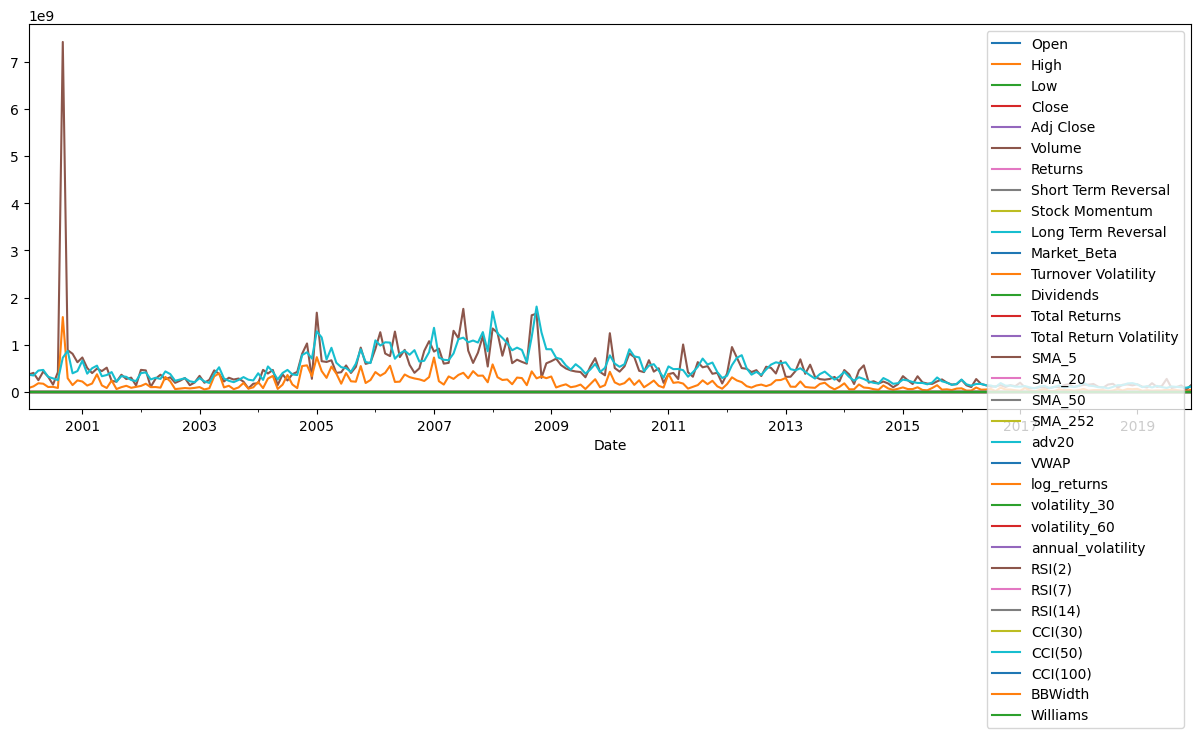

In [7]:

for ticker in ['AAPL']:
    ticker_data = pd.read_csv(
        f"data/{ticker}.csv", index_col='Date', parse_dates=True)
    print(ticker_data.head())
    ticker_data.resample('M').last().plot(figsize=(15, 5))
    print(ticker_data.head())
    ticker_data['Next Day Close'] = ticker_data['Close'].shift(-1)
    ticker_data.dropna(inplace=True)
    # print(ticker_data.head())
    features = ticker_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
                            'Returns', 'Short Term Reversal', 'Stock Momentum',
                            'Long Term Reversal', 'Market_Beta', 'Turnover Volatility', 'Dividends',
                            'Total Returns', 'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50',
                            'SMA_252', 'adv20', 'VWAP', 'log_returns', 'volatility_30',
                            'volatility_60', 'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)',
                            'CCI(30)', 'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams']]

    target = ticker_data['Next Day Close']

    train, test = train_test_split(ticker_data, 0.3)

    X_train = train[:, :-1]  # input as columns
    y_train = train[:, -1]  # output as rows

    # Building RF model
    '''
    random_forest = RandomForestRegressor(
        n_jobs=-1, random_state=123, oob_score=True)
    
    param_grid = {
        'n_estimators': [100, 125, 130, 150],
        'max_depth': [15, 10, 20, 25, None],
        'min_samples_leaf': [75, 100, 125],
        'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
        'max_features': [None, 'sqrt', 'log2'],
    }

    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    print(f"Best Params: {grid_search.best_params_}")
    
    rf = RandomForestRegressor(
        oob_score=True, n_jobs=-1, random_state=123, **grid_search.best_params_)
    '''
    rf = RandomForestRegressor(criterion='friedman_mse', max_depth=None, max_features=None,
                               min_samples_leaf=75, n_estimators=150, n_jobs=-1, random_state=123, oob_score=True)
    # Walk Forward Validation
    y_actual, y_pred = walk_forward_validate(ticker_data, 0.3, rf)

    # Add the predictions to the dataframe only for the test data, avoid look ahead bias
    ticker_data['Next Day Close Predictions'] = np.nan
    ticker_data.iloc[-len(test):,
                     ticker_data.columns.get_loc('Next Day Close Predictions')] = y_pred
    ticker_data[['Next Day Close', 'Next Day Close Predictions']].plot(
        figsize=(15, 5))

    data = ticker_data[['Next Day Close', 'Next Day Close Predictions']]
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    # data.resample('M').prod().plot(figsize=(15, 5))

    ticker_data['Returns Predictions'] = (
        ticker_data['Next Day Close Predictions'] - ticker_data['Close']) / ticker_data['Close'] + 1
    ticker_data['Returns'] = (ticker_data['Next Day Close'] -
                              ticker_data['Close']) / ticker_data['Close'] + 1

    final_df = ticker_data['Returns Predictions'].resample('M').prod()
    final_df = pd.DataFrame(final_df)

    df_close = ticker_data['Close'].resample('M').last()
    df_close = pd.DataFrame(df_close)
    final_df['Close'] = df_close['Close']
    final_df.dropna(inplace=True)
    final_df.to_csv(f"predictions/{ticker}_predictions.csv")




In [10]:
ticker_data = pd.read_csv(
    f"data/AAPL.csv", index_col='Date', parse_dates=True)
ticker_data.head()



,Open,High,Low,Close,Adj Close,Volume,Returns,Short Term Reversal,Stock Momentum,Long Term Reversal,...,volatility_60,annual_volatility,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),BBWidth,Williams
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-02,0.899554,0.911830,0.866071,0.882254,0.748854,464195200,0.985661,-0.103234,-0.103234,-0.035977,...,0.334862,0.615731,12.887812,38.601964,46.032351,-52.968329,-38.058805,50.075000,0.271230,-78.232938
2000-02-03,0.895647,0.930804,0.895089,0.922433,0.782958,475193600,1.045541,-0.060796,-0.060796,-0.006610,...,0.326373,0.613843,68.872138,49.082313,50.475236,-4.110540,0.497970,65.042087,0.271101,-67.361058
2000-02-04,0.928013,0.982143,0.925223,0.964286,0.818483,425320000,1.045372,0.062731,0.062731,0.136843,...,0.320394,0.613414,86.691183,57.830098,54.662242,61.334045,57.788830,86.151739,0.264072,-49.999777
2000-02-07,0.964286,1.020089,0.945871,1.018415,0.864427,441067200,1.056134,0.099398,0.099398,0.146356,...,0.324097,0.614508,94.635062,66.511261,59.438451,112.326875,108.180699,104.977473,0.275773,-27.546248
2000-02-08,1.017857,1.036830,0.993304,1.025670,0.870585,408643200,1.007124,0.145886,0.145886,0.175192,...,0.324073,0.614204,95.375077,67.555676,60.045999,134.926973,135.553646,115.982182,0.282727,-24.536729


In [17]:
monthly = ticker_data.resample('M').()  
monthly.head()
#ticker_data['Next Day Close'] = ticker_data['Close'].shift(-1)


,Open,High,Low,Close,Adj Close,Volume,Returns,Short Term Reversal,Stock Momentum,Long Term Reversal,...,annual_volatility,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),BBWidth,Williams,Next Day Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,1.013951,1.046875,1.005022,1.023438,0.868690,368961600,1.012141,0.007139,0.007139,0.104820,...,0.612507,68.393687,54.580391,54.728379,72.927008,94.343287,102.076463,0.192096,-40.094175,1.163504
2000-03-31,1.137835,1.225446,1.125000,1.212612,1.029261,404633600,1.080020,-0.020730,-0.020730,0.061036,...,0.638687,62.761434,55.428512,56.973118,71.596371,106.604406,145.223706,0.278727,-40.034216,1.190290
2000-04-30,1.135045,1.138393,1.083147,1.107701,0.940213,249580800,0.978797,0.043638,0.043638,-0.013420,...,0.648004,45.656858,51.116341,50.167061,-28.954086,3.774483,66.334151,0.224527,-31.165962,1.109933
2000-05-31,0.775670,0.814732,0.748326,0.750000,0.636597,433507200,0.959315,-0.021122,-0.021122,-0.287380,...,0.652984,14.894631,24.604813,31.369145,-117.572918,-145.521624,-175.654692,0.411983,-92.174022,0.795759
2000-06-30,0.943080,0.981027,0.922991,0.935268,0.793852,323097600,1.021951,0.013301,0.013301,0.131668,...,0.671758,50.222212,54.418957,53.700598,109.051348,22.418148,-38.199475,0.276830,-38.799012,0.952009


In [28]:
from sklearn.model_selection import train_test_split, cross_val_score
from metrics import stacking_predict
tickers = ['AAPL']
for ticker in tickers:
    ticker_data = pd.read_csv(f"data/{ticker}.csv", index_col=0)
    ticker_data['Next Day Close'] = ticker_data['Close'].shift(-1)
    ticker_data.dropna(inplace=True)
    # print(ticker_data.head())
    features = ticker_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
                            'Returns', 'Short Term Reversal', 'Stock Momentum',
                            'Long Term Reversal', 'Market_Beta', 'Turnover Volatility', 'Dividends',
                            'Total Returns', 'Total Return Volatility', 'SMA_5', 'SMA_20', 'SMA_50',
                            'SMA_252', 'adv20', 'VWAP', 'log_returns', 'volatility_30',
                            'volatility_60', 'annual_volatility', 'RSI(2)', 'RSI(7)', 'RSI(14)',
                            'CCI(30)', 'CCI(50)', 'CCI(100)', 'BBWidth', 'Williams']]

    target = ticker_data['Next Day Close']

    X = np.array(features).reshape(-1, 33)  # input as columns
    y = np.array(target)  # output as rows

    feature_train, feature_test, target_train, target_test = train_test_split(
        X, y, test_size=0.3, random_state=0)

    # Building RF model
    '''
    random_forest = RandomForestRegressor(
        n_jobs=-1, random_state=123, oob_score=True)
    
    param_grid = {
        'n_estimators': [100, 125, 130, 150],
        'max_depth': [15, 10, 20, 25, None],
        'min_samples_leaf': [75, 100, 125],
        'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
        'max_features': [None, 'sqrt', 'log2'],
    }

    grid_search = GridSearchCV(
        estimator=random_forest, param_grid=param_grid, cv=5)
    grid_search.fit(feature_train, target_train)

    print(grid_search.best_params_)

    criterion, max_depth, max_features, min_samples_leaf, n_estimators = grid_search.best_params_.values()

    # Building MLP model
    mlp = MLPRegressor(max_iter=1000)

    param_grid = {
        'hidden_layer_sizes': [(50, 50), (100, 50, 25), (100, 100), (50, 50, 50)],
        'activation': ['relu', 'tanh', 'identity'],
        # 'learning_rate': ['constant', 'adaptive'],
        'alpha': [0.0001, 0.001, 0.01],
    }

    # Create a GridSearchCV instance
    grid_search = GridSearchCV(mlp, param_grid, cv=5,
                               n_jobs=-1, scoring='neg_mean_squared_error')

    # Fit the GridSearchCV to find the best hyperparameters
    grid_search.fit(feature_train, target_train)

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    print(best_params)
    base_models = [
        ('rf', RandomForestRegressor(criterion=criterion, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators,
                                     oob_score=True, random_state=123, n_jobs=-1)),
        ('nn', MLPRegressor(max_iter=1000, **best_params))
    ]
    '''
    base_models = [
        ('rf', RandomForestRegressor(criterion='absolute_error', max_depth=10, max_features='sqrt', min_samples_leaf=75, n_estimators=130,
                                     oob_score=True, random_state=123, n_jobs=-1)),
        ('nn', MLPRegressor(max_iter=1000, activation='tanh', alpha=0.001, hidden_layer_sizes=(50, 50, 50)))
    ]

    meta_learner = GradientBoostingRegressor(
        random_state=42, n_estimators=750, learning_rate=0.01, max_depth=5, max_features='sqrt')
    '''
    stack_model = StackingRegressor(
        estimators=base_models, final_estimator=meta_learner)

    # Grid Search for meta learner
    param_grid = {
        'final_estimator__n_estimators': [250, 225, 275],
        'final_estimator__learning_rate': [0.01, 0.05, 0.1, 0.2],
        # Example parameter choices
        'final_estimator__max_depth': [6, 5, 8, None]
    }

    grid_search = GridSearchCV(estimator=stack_model, param_grid=param_grid,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(feature_train, target_train)
    print(grid_search.best_params_)

    # best_params = grid_search.best_params_
    best_meta_learner = grid_search.best_estimator_
    '''
    #final_stack_model = StackingRegressor(
    #    estimators=base_models, final_estimator=best_meta_learner)
    
    final_stack_model = StackingRegressor(
        estimators=base_models, final_estimator=meta_learner)
    
    # Fit the stacking model on the training data + Walk Forward Validation
    predictions = np.array([])
    print(feature_test.shape)
    print(target_test.shape)
    history_features = [x for x in feature_train]
    history_targets = [x for x in target_train]
    for i in range(len(feature_test)):
        X_test, y_test = feature_test[i, :], target_test[i]
        pred = stacking_predict(history_features, history_targets, X_test, y_test, final_stack_model)
        predictions = np.append(predictions, pred)
        
        history_feat.append(feature_test[i, :])    

    
    # print(confusion_matrix(target_test, grid_search_predictions))
    print(f"Mean Absolute Error: {mean_absolute_error(target_test, predictions)}")
    print(f"Mean Squared Error: {mean_squared_error(target_test, predictions)}")
    print(f"R^2: {r2_score(target_test, predictions)}")

    # Add the predictions to the dataframe only for the test data, avoid look ahead bias
    ticker_data['Next Day Close Predictions'] = np.nan
    ticker_data.iloc[-len(feature_test):,
                     ticker_data.columns.get_loc('Next Day Close Predictions')] = predictions
    ticker_data[['Next Day Close', 'Next Day Close Predictions']].plot(
        figsize=(15, 5))

    data = ticker_data[['Next Day Close', 'Next Day Close Predictions']]
    data.dropna(inplace=True)
    data.index = pd.to_datetime(data.index)
    #data.resample('M').prod().plot(figsize=(15, 5))


ImportError: cannot import name 'stacking_predict' from 'metrics' (c:\Users\yinki\OneDrive\Python\RF Portfolio Optimization\metrics.py)